In [19]:
# Box prediction
# Trying again!
import time
from PIL import Image, ImageDraw
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os

import seaborn as sns
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.transforms as mplTransforms
plt.style.use('ggplot')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# ---- Make depth images ------------------------------------
# -----------------------------------------------------------
IMG_X, IMG_Y = 200, 200
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30

batch_size = 15


# -- Calc rectangle vertices. credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l / 2.0, w / 2.0), (l / 2.0, -w / 2.0),
                  (-l / 2.0, -w / 2.0), (-l / 2.0, w / 2.0)]
    return [(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords]


# ---- Save to file -------------------
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = "./" + dirname
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        # orient = 0 # degrees
        img = Image.new("RGB", (IMG_X, IMG_Y), "black")

        # block_l and _w offset so blocks don't run off edge of image
        rand_x = int(np.random.rand() * (IMG_X - 2 * block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y - 2 * block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient)  # math.cos takes radians!

        rect_vertices = makeRectangle(
            block_l, block_w, orient, offset=(rand_x, rand_y))

        # true_coords.append(np.array((rand_x, rand_y, math.degrees(orient))))
        true_coords.append(np.array((rand_y, rand_x, math.degrees(orient))))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill="white")

        img.save(newpath + "/rect" + str(i) + ".png")
    return true_coords


# ---- Define dataloader ------------------------------------
# -----------------------------------------------------------
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        # print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect' + str(idx) + '.png')
        image = torch.FloatTensor(image).permute(
            2, 0, 1)  # PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample


# ---- Define Net ------------------------------------
# ----------------------------------------------------
class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28pred_x)
    def __init__(self, IMG_X, IMG_Y):
        super(Net, self).__init__()

        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16

        num_classes = 3

        def _calc(val):
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        # print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers
        # print(self._const)
        self._const = int(self._const)

        self.conv1 = nn.Conv2d(3, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, num_classes).to(device)

    def forward(self, x):
        # print(x.size())
        x = x.to(device)
        x = x.view(-1, 3, IMG_X, IMG_Y)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# -- Utility fxn -------------------------------------
# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/train.py
# ---------------------------------------------------


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(epoch, epochs_since_improvement, regrModel,
                    loss_history,
                    regrLoss, best_loss, is_best):
    # Save checkpoint
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {
        "epoch": epoch,
        "epochs_since_improvement": epochs_since_improvement,
        "regrModel": regrModel,
        "regrLoss": regrLoss,
        "loss_history": loss_history,
        "best_loss": best_loss,
        "is_best": is_best
    }

    filename = "checkpoint_attempt2.tar"
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, "BEST_" + filename)

# -- Main Functions --------------------------------------------------
# --------------------------------------------------------------------


def run_dataset_creation():
    train_truth = make_dataset('data', 500)
    print(len(train_truth))
    test_truth = make_dataset('./data/test', 300)
    # to things

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("CUDA available? device: ", device)

    # Dataset is depth images of rectangular blocks
    global train_loader
    train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)
    # Data loader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True)

    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    np.save("train_truth.npy", train_truth)
    np.save("test_truth.npy", test_truth)


def train_dataset():

    num_classes = 3  # predicting x,y,orientation
    learning_rate = 0.001
    criterion = nn.MSELoss()
    num_epochs = 20

    print_freq = 25  # print training or validation status every __ batches
    epochs_since_improvement = 0
    best_loss = 5000.0  # assume a high loss at first

    train_truth = np.load("train_truth.npy")
    # loading the training and testing data5
    test_truth = np.load("test_truth.npy")

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    loss_avg = AverageMeter()  # loss
    loss_history = []

    # -- Instantiate CNN -------------------------
    regrModel = Net(IMG_X, IMG_Y)
    regrModel = regrModel.to(device)
    optimizer = torch.optim.Adam(regrModel.parameters(), lr=learning_rate)

    regrModel.train()  # enable dropout
    print('Training model now...')

    # -- Load datasets -------------------------
    train_truth = np.load("train_truth.npy")
    train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True)

    # -- Begin training -------------------------
    start = time.time()

    for epoch in range(num_epochs):

        for i_batch, (images, labels) in enumerate(train_loader):
            data_time.update(time.time() - start)

            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = regrModel(images).to(device)

            regrLoss = criterion(outputs, labels)
            loss_history.append(regrLoss)

            optimizer.zero_grad()
            regrLoss.backward()

            # Update Model
            optimizer.step()

            loss_avg.update(regrLoss.item())

            # Print status
            batch_time.update(time.time() - start)
            start = time.time()

            if i_batch % print_freq == 0:
                print(
                    "Epoch: [{0}][{1}/{2}]\t"
                    "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                    "CLoss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                        epoch,
                        i_batch,
                        len(train_loader),
                        batch_time=batch_time,
                        loss=loss_avg,
                    )
                )

        # One epoch's loss
        is_best = loss_avg.avg < best_loss
        best_loss = min(loss_avg.avg, best_loss)

        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d, %d loss\n" %
                  (epochs_since_improvement, loss_avg.avg))

        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(epoch, epochs_since_improvement, regrModel,
                        loss_history,
                        loss_avg.avg, best_loss, is_best)


# --- VIEW RESULTS ----------------------------------------
# ---------------------------------------------------------

def view_loss_results():
    filename = "checkpoint_attempt2.tar"
    checkpoint = torch.load(filename)
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    loss_history = checkpoint['loss_history']
    regrModel = checkpoint['regrModel']

    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' %
          (start_epoch, best_loss))
    test_truth = np.load("test_truth.npy")
    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    criterion = nn.MSELoss()

    with torch.no_grad():

        dataiter = iter(test_loader)
        images, labels = dataiter.next()

        # Move to default device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = regrModel(images)
        loss = criterion(outputs, labels)

        # Loss
        print("loss across batch size of ", labels.size()[0], 'is: \n', loss)

        # print(labels)
        print('\n!-- labels size', labels.size())

        plt.plot(range(len(loss_history)), loss_history)  # regr loss
        plt.show()
        # plt.xlim((4500, 5100))
        # plt.ylim((0,30))
        # plt.show()

        # sns.regplot(x=np.arange(len(loss_history)),
        # y=np.array(loss_history)) # regr loss


def view_image_results():
    filename = "checkpoint_attempt2.tar"
    checkpoint = torch.load(filename)
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    loss_history = checkpoint['loss_history']
    regrModel = checkpoint['regrModel']

    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' %
          (start_epoch, best_loss))

    test_truth = np.load("test_truth.npy")
    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    criterion = nn.MSELoss()

    with torch.no_grad():

        dataiter = iter(test_loader)
        images, coords = dataiter.next()

        # Move to default device
        images = images.to(device)
        coords = coords.to(device)

        # Forward pass
        outputs = regrModel(images)

        labels = coords.cpu()

        plt.rcParams['figure.figsize'] = [50, 10]

        fig, ax = plt.subplots()

        print('lenlabels', len(labels))
        print(block_l, block_w, IMG_X, IMG_Y)

        for i in range(len(labels) - 10):
            #print('i', i)
            x, y, orient = labels[i].numpy()
            pred_x, pred_y, pred_orient = outputs[i].cpu().numpy()

            orient = np.deg2rad(orient)
            pred_orient = np.deg2rad(pred_orient)

            # lower left
            cornerX, cornerY = x - (block_w / 2.), y - ((block_l / 2.))
            #print('x,y', x, y, 'corners', cornerX, cornerY, 'orient', orient)
            predCornerX, predCornerY = pred_x - \
                (block_w / 2.), pred_y - ((block_l / 2.))

            print(cornerX, cornerY, x, y, orient)
            truth_rect = patches.Rectangle((cornerX + i * IMG_X, cornerY), block_w, block_l,
                                           angle=0, fill=True, color='black')
            # correct for rotation around LL corner
            rotat = mplTransforms.Affine2D().rotate_around(x + i * IMG_X, y, orient)
            truth_rect.set_transform(rotat + ax.transData)
            print(truth_rect.get_xy())

            ax.add_patch(truth_rect)
            # pred_rect = patches.Rectangle((predCornerX + i * IMG_X, predCornerY), block_l,
            # block_w, angle = 0, fill=True, color='orange')
            # image_outline = patches.Rectangle((i * IMG_X, 0), 200, 200, angle=0,
            # fill=False, color='black')

            # ax.add_patch(pred_rect)
            # ax.add_patch(image_outline)

            # Scatter plot of true centers
            ax.scatter(x + i * IMG_X, y, color='r', marker='x', linewidth='1',
                       zorder=100)
        # plt.imshow(np.transpose(a, (2,0,1)))
        ax.set_aspect('equal', 'box')
        plt.show()


def main():
    #print('Creating dataset')
    #run_dataset_creation()

    #print('Training model')
    #train_dataset()

    print('View results')

    # view_loss_results()

    view_image_results()

    #input('Close all?')
    plt.close('all')


#if __name__ == '__main__':
    #main()

CUDA available? device:  cuda:0


View results

Loaded checkpoint from epoch 20. Best loss so far is 237.188.

lenlabels 15
20 30 200 200
143.0 21.0 158.0 31.0 1.6929693
(143.0, 21.0)
121.0 143.0 136.0 153.0 1.6580628
(321.0, 143.0)
143.0 95.0 158.0 105.0 0.41887903
(543.0, 95.0)
130.0 128.0 145.0 138.0 2.4783676
(730.0, 128.0)
52.0 93.0 67.0 103.0 3.0019662
(852.0, 93.0)


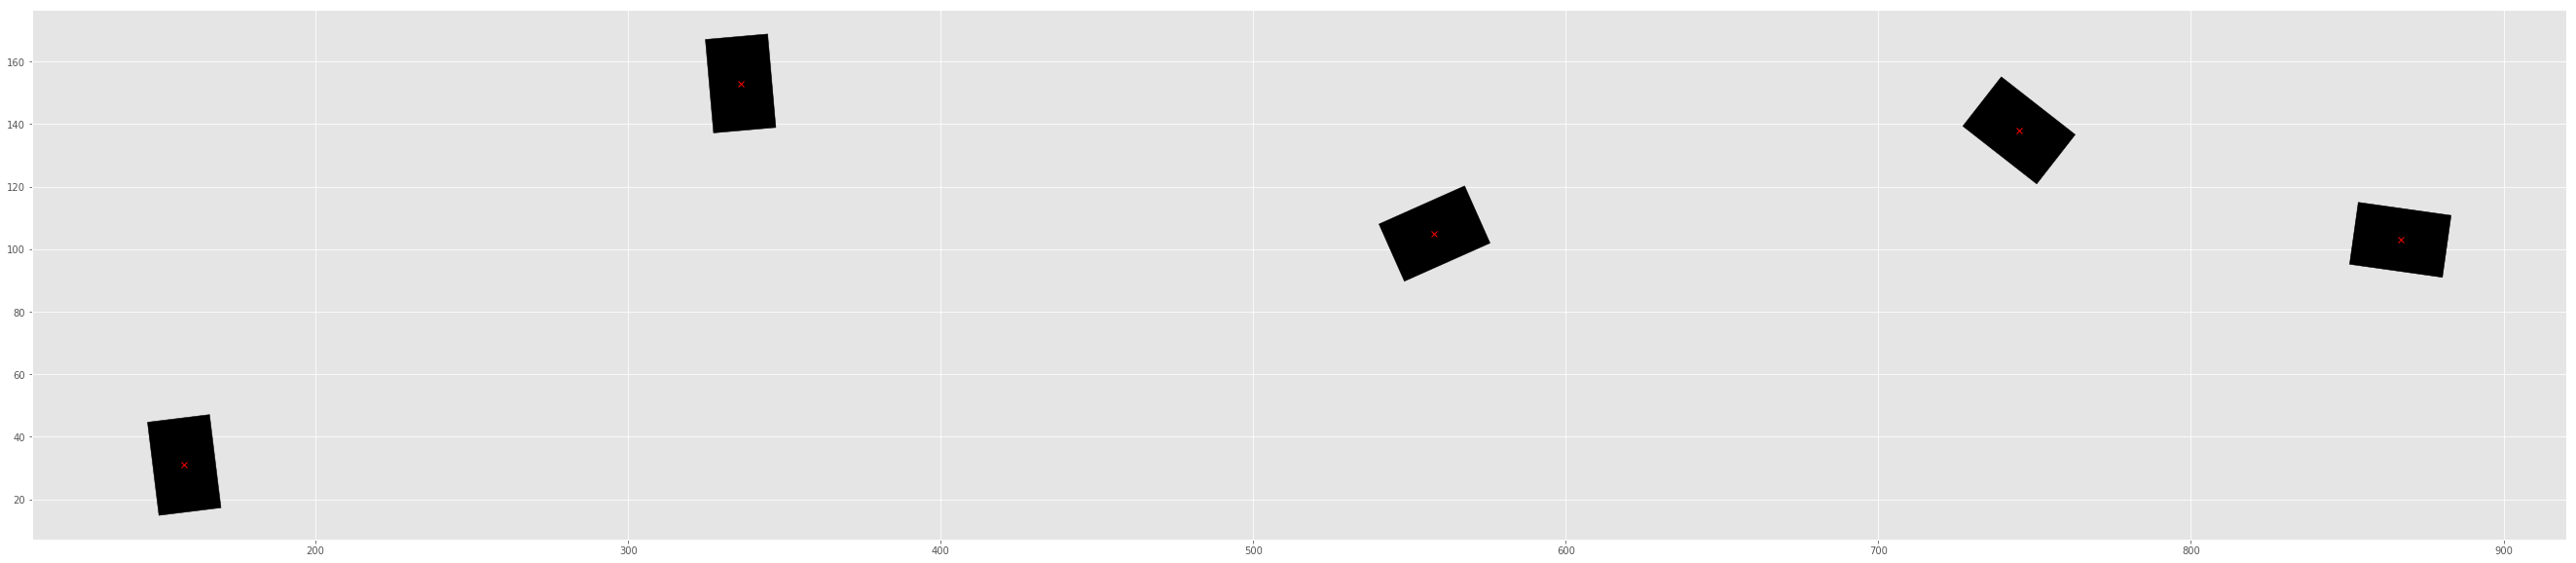

In [20]:
main()